In [1]:
import sympy as sym

import numpy as np

import repeated_play

In [2]:
import itertools

In [3]:
from tqdm.notebook import tqdm

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
def trnsf_transition_m_memory_one(player, analytical=True):
    
    if analytical == True:
        M = sym.Matrix([[player[0], (1 - player[0])],
                        [player[1], (1 - player[1])]])
    else:
        M = np.array([[player[0], (1 - player[0])],
                        [player[1], (1 - player[1])]])
    return M

In [7]:
def trnsf_transition_m_memory_two(player, analytical=True):
    
    if analytical == True:
        M = sym.Matrix([[player[0], (1 - player[0]), 0, 0],
                        [0, 0, player[1], (1 - player[1])],
                        [player[2], (1 - player[2]), 0, 0],
                        [0, 0, player[3], (1 - player[3])]])
    else:
        M = np.array([[player[0], (1 - player[0]), 0, 0],
                        [0, 0, player[1], (1 - player[1])],
                        [player[2], (1 - player[2]), 0, 0],
                        [0, 0, player[3], (1 - player[3])]])
    
    
    return M

In [8]:
def trnsf_transition_m_memory_three(player, analytical=True):
    if analytical == False:
        return np.array(
            [
                [player[0], (1 - player[0]), 0, 0, 0, 0, 0, 0],
                [0, 0, player[1], (1 - player[1]), 0, 0, 0, 0],
                [0, 0, 0, 0, player[2], (1 - player[2]), 0, 0],
                [0, 0, 0, 0, 0, 0, player[3], (1 - player[3])],
                [player[4], (1 - player[4]), 0, 0, 0, 0, 0, 0],
                [0, 0, player[5], (1 - player[5]), 0, 0, 0, 0],
                [0, 0, 0, 0, player[6], (1 - player[6]), 0, 0],
                [0, 0, 0, 0, 0, 0, player[7], (1 - player[7])],
            ]
        )

    if analytical == True:
        return sym.Matrix(
            [
                [player[0], (1 - player[0]), 0, 0, 0, 0, 0, 0],
                [0, 0, player[1], (1 - player[1]), 0, 0, 0, 0],
                [0, 0, 0, 0, player[2], (1 - player[2]), 0, 0],
                [0, 0, 0, 0, 0, 0, player[3], (1 - player[3])],
                [player[4], (1 - player[4]), 0, 0, 0, 0, 0, 0],
                [0, 0, player[5], (1 - player[5]), 0, 0, 0, 0],
                [0, 0, 0, 0, player[6], (1 - player[6]), 0, 0],
                [0, 0, 0, 0, 0, 0, player[7], (1 - player[7])],
            ]
        )

In [9]:
def match_payoffs_efficiently(player, coplayer, b, c, memory):
    if memory == "one":
        M = trnsf_transition_m_memory_one(coplayer, analytical=False)
    elif memory == "two":
        M = trnsf_transition_m_memory_two(coplayer, analytical=False)
    elif memory == "three":
        M = trnsf_transition_m_memory_three(coplayer, analytical=False)

    ss = repeated_play.stationary_distribution(M)[0]
    
    if memory == "one":
        rho_q = ss[0]
        
    elif memory == "two":
        
        rho_q = ss[0] + ss[1]
        
    elif memory == "three":
        
        rho_q = ss[0] + ss[1] + ss[4] + ss[5]
        

    rho_p = sum([ss[i] * p for i, p in enumerate(player)])


    payoff_q = (rho_p * b - c * rho_q)
    
    return payoff_q

In [10]:
def match_payoffs(player, coplayer, b, c, memory):
    if memory == 'one':
        assert(len(player) == 2)
        assert(len(coplayer) == 2)
    
    if memory == 'two':
        assert(len(player) == 4)
        assert(len(coplayer) == 4)
    
    if memory == 'three':
        assert(len(player) == 8)
        assert(len(coplayer) == 8)
    
    return match_payoffs_efficiently(player, coplayer, b, c, memory)

### Over costs

In [11]:
costs = np.linspace(0, 1, 11)

memories = ['one', 'two', 'three']

pure_strategies = [list(itertools.product([0, 1], repeat=2)),
                   list(itertools.product([0, 1], repeat=4)),
                   list(itertools.product([0, 1], repeat=8))]

dims = [2, 4, 8]

In [338]:
max_iterations = 10 ** 4

bval = 1;

for cval in tqdm(costs):

    base = f"DefectingNash/cost_{cval}_"

    dnash, gnash, notdnash, notgnash = [], [], [], []

    for memory, pure_set, sdim in zip(memories, pure_strategies, dims):

        for i in range(max_iterations):

            np.random.seed(i)

            player = np.random.random(sdim)

            defecting_player = player.copy()
            defecting_player[-1] = 0

            cooperative_player = player.copy()
            cooperative_player[0] = 1

            checksA, checksB = [], []

            for coplayer in pure_set:

                payoff_defective = match_payoffs(defecting_player, coplayer, bval, cval, memory=memory)

                checkA = np.isclose(payoff_defective, 0, atol=10 ** -4) or payoff_defective < 0

                checksA.append(checkA)


                payoff_cooperative = match_payoffs(cooperative_player, coplayer, bval, cval, memory=memory)

                checkB = np.isclose(payoff_cooperative, bval - cval, atol=10 ** -4) or payoff_cooperative < (bval - cval)

                checksB.append(checkB)

            if all(checksA) == True:
                dnash.append([i, *defecting_player, *checksA, memory])
            else:
                notdnash.append([i, *defecting_player, *checksA, memory])


            if all(checksB) == True:
                gnash.append([i, *cooperative_player, *checksB, memory])
            else:
                notgnash.append([i, *cooperative_player, *checksB, memory])

    ddf = pd.DataFrame(dnash)
    nddf = pd.DataFrame(notdnash)

    gdf = pd.DataFrame(gnash)
    ngdf = pd.DataFrame(notgnash)

    ddf.to_csv(base + 'defective_Nash')

    nddf.to_csv(base + 'defective_not_Nash')

    gdf.to_csv(base + 'cooperative_Nash')

    ngdf.to_csv(base + 'cooperative_not_Nash')

  0%|          | 0/11 [00:00<?, ?it/s]

In [13]:
columns = ['index', "pc", "pd"] + [f"N{i}" for i in range(1, 5)] + ['memory']

In [14]:
defective_files = [f'DefectingNash/cost_{cval}_defective_Nash' for cval in costs]

cooperative_files = [f'DefectingNash/cost_{cval}_cooperative_Nash' for cval in costs]

In [15]:
len(defective_files)

11

In [16]:
data = np.zeros((11, 3))

for i, file in enumerate(defective_files):
    
    df = pd.read_csv(file, header=0, low_memory=False, index_col=0)
    
    if len(df) > 0:

        if "7" in df.columns:
            data[i, 0] = df[df["7"] == 'one']["0"].nunique()

        if "21" in df.columns:
            data[i, 1] = df[df["21"] == 'two']["0"].nunique()

        if "265" in df.columns:
            data[i, 2] = df[df["265"] == 'three']["0"].nunique()

In [17]:
coop_data = np.zeros((11, 3))

for i, file in enumerate(cooperative_files):
    
    df = pd.read_csv(file, header=0, low_memory=False, index_col=0)
    
    if len(df) > 0:

        if "7" in df.columns:
            coop_data[i, 0] = df[df["7"] == 'one']["0"].nunique()

        if "21" in df.columns:
            coop_data[i, 1] = df[df["21"] == 'two']["0"].nunique()

        if "265" in df.columns:
            coop_data[i, 2] = df[df["265"] == 'three']["0"].nunique()

In [18]:
linestyles = ["-", "--", ":"]

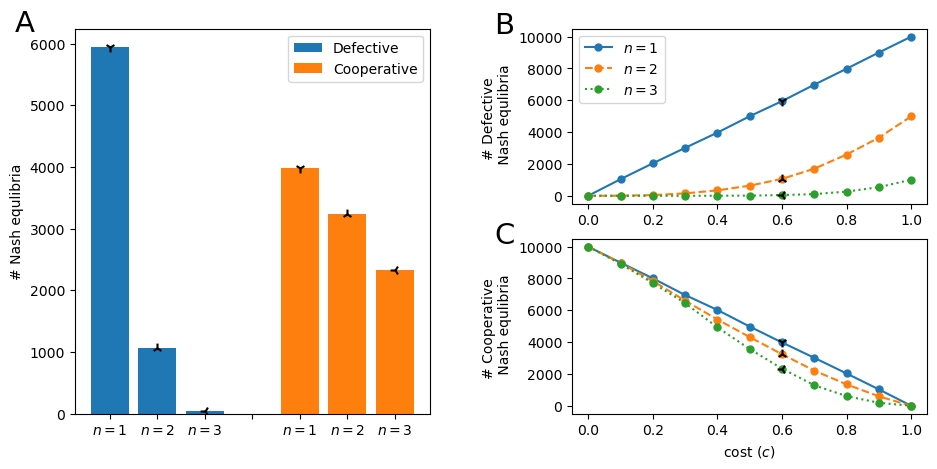

In [73]:
fig, axes = plt.subplot_mosaic("AB;AC", figsize=(11, 5))


axes["A"].bar(range(3), data[6], label="Defective");

for i, point in zip(range(3), data[6]):
    axes["A"].scatter(i, point, marker=f"{i + 1}", zorder=3, s=50, color="black");

axes["A"].bar(range(4, 7), coop_data[6], label="Cooperative");

for i, point in zip(range(4, 7), coop_data[6]):
    axes["A"].scatter(i, point, marker=f"{i - 3}", zorder=3, s=50, color="black");

axes["A"].set_ylabel("# Nash equlibria")

axes["A"].set_xticks(range(7), ["$n=1$", "$n=2$", "$n=3$", "", "$n=1$", "$n=2$", "$n=3$",])

axes["A"].text(-2, 6.2 * 10 ** 3, "A", fontsize=21)

axes["B"].plot(costs, data, marker='o', label=["$n=1$", "$n=2$", "$n=3$"], markersize=5);

axes["B"].scatter(costs[6], data[6][0], marker='1', zorder=3, s=50, color="black");
axes["B"].scatter(costs[6], data[6][1], marker='2', zorder=3, s=50, color="black");
axes["B"].scatter(costs[6], data[6][2], marker='3', zorder=3, s=50, color="black");


axes["B"].set_ylabel("# Defective \n Nash equlibria")

for line, ls in zip(axes["B"].get_lines(), linestyles):
    line.set_linestyle(ls)
    
axes["B"].text(-.29, 10.2 * 10 ** 3, "B", fontsize=21)

axes["C"].scatter(costs[6], coop_data[6][0], marker='1', zorder=3, s=50, color="black");
axes["C"].scatter(costs[6], coop_data[6][1], marker='2', zorder=3, s=50, color="black");
axes["C"].scatter(costs[6], coop_data[6][2], marker='3', zorder=3, s=50, color="black");

axes["C"].plot(costs, coop_data, marker='o', markersize=5);

axes["C"].set_ylabel("# Cooperative \n Nash equlibria")

axes["C"].set_xlabel("cost ($c$)")

axes["C"].text(-.29, 10.2 * 10 ** 3, "C", fontsize=21)

axes["A"].legend();

axes["B"].legend();

for line, ls in zip(axes["C"].get_lines(), linestyles):
    line.set_linestyle(ls)
    
    
fig.subplots_adjust(wspace=.4)

fig.savefig("../figures/siFig1.pdf", bbox_inches="tight")